# ROC on openpifpaf

In [2]:
import sys, os

class OutputInhibitor():
    def __init__(self, name=None):
        self.name = name
    def __enter__(self):
        if self.name:
            print("Launching {}... ".format(self.name), end="")
        self.ps1, self.ps2 = getattr(sys, "ps1", None), getattr(sys, "ps2", None)
        if self.ps1:
            del sys.ps1
        if self.ps2:
            del sys.ps2
        self.stderr = sys.stderr
        self.fp = open(os.devnull, "w")
        sys.stderr = self.fp
    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.ps1:
            sys.ps1 = self.ps1
        if self.ps2:
            sys.ps2 = self.ps2
        sys.stderr = self.stderr
        self.fp.close()
        if self.name:
            print("Done.")


In [3]:
from mlworkflow import PickledDataset, TransformedDataset
from dataset_utilities.ds.instants_dataset import ExtractViewData, ViewCropperTransform
with OutputInhibitor():
    from openpifpaf.datasets.deepsport import AddBallSegmentationTargetViewFactory, AddBallPositionFactory

ds = PickledDataset("/scratch/gva/views_camera_with_ball2.pickle")

shape = (800,600)

ds = TransformedDataset(ds, [
    ViewCropperTransform(def_min=30, def_max=80, output_shape=shape),
    ExtractViewData(AddBallPositionFactory(), AddBallSegmentationTargetViewFactory()),
])

In [5]:
import random
keys = list(PickledDataset("/scratch/gva/views_with_human_masks.pickle").keys.all())
random.seed(0)
random.shuffle(keys)
validation_set_size_pc = 15
lim = len(keys)*validation_set_size_pc//100
training_keys = keys[lim:]
validation_keys = keys[:lim]
testing_keys = [k for k in ds.yield_keys() if k not in training_keys and k not in validation_keys]
print(len(validation_keys))
print(len(training_keys))

100
572


In [6]:
import tensorflow as tf
import numpy as np
from tf_layers import AvoidLocalEqualities, PeakLocalMax, ComputeElementaryMetrics
class ChunkProcessor:
    pass
class CastFloat(ChunkProcessor):
    def __init__(self, tensor_name):
        self.tensor_name = [tensor_name] if isinstance(tensor_name, str) else tensor_name
    def __call__(self, chunk):
        for tensor_name in self.tensor_name:
            if tensor_name in chunk:
                chunk[tensor_name] = tf.cast(chunk[tensor_name], tf.float32)
class Normalize(ChunkProcessor):
    def __init__(self, tensor_name):
        self.tensor_name = tensor_name
    def __call__(self, chunk):
        assert chunk[self.tensor_name].dtype == tf.float32
        chunk[self.tensor_name] = chunk[self.tensor_name]/255
class ComputeKeypointsDetectionAccuracy(ChunkProcessor):
    def __init__(self, non_max_suppression_pool_size=50, threshold=0.5, target_enlargment_size=10):
        thresholds = threshold if isinstance(threshold, np.ndarray) else np.array([threshold])
        assert len(thresholds.shape) == 1, "'threshold' argument should be 1D-array (a scalar is also accepted)."

        self.avoid_local_eq = AvoidLocalEqualities()
        self.peak_local_max = PeakLocalMax(min_distance=non_max_suppression_pool_size//2, thresholds=thresholds)
        self.enlarge_target = tf.keras.layers.MaxPool2D(target_enlargment_size, strides=1, padding="same")
        self.compute_metric = ComputeElementaryMetrics()

    def __call__(self, chunk):
        batch_target = tf.cast(chunk["batch_target"], tf.float32)
        batch_target = batch_target if len(batch_target.shape) == 4 else batch_target[...,tf.newaxis]
        batch_output = chunk["batch_heatmap"]
        batch_output = batch_output if len(batch_output.shape) == 4 else batch_output[...,tf.newaxis]

        batch_output = self.avoid_local_eq(batch_output)
        batch_hitmap = self.peak_local_max(batch_output)
        batch_hitmap = tf.cast(batch_hitmap, tf.int32)
        chunk["batch_hitmap"] = tf.squeeze(batch_hitmap)
        batch_target = self.enlarge_target(batch_target)
        batch_target = tf.cast(batch_target, tf.int32)[..., tf.newaxis]

        batch_metric = self.compute_metric(batch_hitmap=batch_hitmap, batch_target=batch_target)
        chunk["batch_TP"] = tf.squeeze(batch_metric["batch_TP"])
        chunk["batch_FP"] = tf.squeeze(batch_metric["batch_FP"])
        chunk["batch_TN"] = tf.squeeze(batch_metric["batch_TN"])
        chunk["batch_FN"] = tf.squeeze(batch_metric["batch_FN"])

        
chunk = {}
chunk["batch_heatmap"] = tf.keras.Input(dtype=tf.uint8, shape=(shape[1], shape[0]), name="batch_heatmap")
chunk["batch_target"] = tf.keras.Input(dtype=tf.uint8, shape=(shape[1], shape[0]), name="batch_target")
inputs = dict(chunk) # makes a copy

thresholds = np.array([])
n_points = 21
chunk_processors = [
    CastFloat(["batch_heatmap", "batch_target"]),
    Normalize("batch_heatmap"),
    ComputeKeypointsDetectionAccuracy(non_max_suppression_pool_size=20, threshold=np.linspace(0,1,n_points)),
]
for cp in chunk_processors:
    cp(chunk)

outputs = {k:chunk[k] for k in chunk if k in ["batch_TP", "batch_TN", "batch_FP", "batch_FN"]}
model = tf.keras.Model(inputs, outputs)

In [7]:
from matplotlib import pyplot as plt
def plot_roc(current_result, set_name, fig=None):
    fig = fig or plt.figure()
    x = current_result["FP"]/(current_result["FP"]+current_result["TN"])
    y = current_result["TP"]/(current_result["TP"]+current_result["FN"])
    ax = fig.gca()
    ax.plot(x, y, linestyle="-", linewidth=1, markersize=5, marker=".", label=set_name)
    index=10
    ax.plot(x[index], y[index], markersize=10, marker=".", color="green")
    ax.set_xlabel("FP rate")
    ax.set_ylabel("TP rate")
    ax.axis("equal")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_box_aspect(1)
    ax.set_title(f"ROC ball detection from PIFPAF")
    ax.legend()
    return fig

In [8]:
from matplotlib import pyplot as plt
def plot_F1(current_result, set_name, fig=None):
    fig = fig or plt.figure()
    x = np.linspace(0,1,n_points)
    y = current_result["TP"]/(current_result["TP"]+0.5*(current_result["FP"]+current_result["FN"]))
    ax = fig.gca()
    ax.plot(x, y, linestyle="-", linewidth=1, markersize=5, marker=".", label=set_name)
    index=10
    ax.plot(x[index], y[index], markersize=10, marker=".", color="green")
    ax.set_xlabel("threshold")
    ax.set_ylabel("F1 score")
    ax.axis("equal")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_box_aspect(1)
    ax.set_title(f"F1 score for ball detection")
    ax.legend()
    return fig

In [9]:
from IPython import display
from ipywidgets import Output

output = Output()
display.display(output)

Output()

In [10]:
def infer(weight_file, data):
    image_filename = "tmp_image.png"
    imageio.imwrite(image_filename, data["input_image"])
    sys.argv = [
        "aue",
        image_filename,
        "--checkpoint", weights_file,
        "--image-output",
        "--debug-images", "--debug-cif-c", "--debug"
    ]
    with OutputInhibitor():
        main()
    return imageio.imread("image/test.accumulated.png")

In [18]:
import os
from tqdm.notebook import tqdm
from openpifpaf.predict import main
import sys
import imageio
import numpy as np
import pickle

#weights_file = "shufflenetv2k16w-210225-164102-ball-edge501.pkl.epoch150" # trained on small dataset
#weights_file = "shufflenetv2k16w-210308-164747-ball-edge501.pkl.epoch150" # trained on full dataset
#weights_file = "shufflenetv2k16-210309-153430-ball-edge501.pkl.epoch200" # trained on small dataset with fixed seed
#weights_file = "shufflenetv2k16-210309-220522-ball.pkl.epoch499" # trained on small dataset with fixed seed

import glob
#for filename in glob.glob("outputs/resnet*.log"):
#for filename in glob.glob("outputs/*210312-0[89]*.log"):
filename = "outputs/resnet50-210311-144027.099429-ball-edge641.pkl.log"
for filename in glob.glob("outputs/*210312-*.log"):
    weights_file = filename.replace(".log", ".epoch100")
    if not os.path.isfile(weights_file):
        continue
    
    sets_results = {}
    for set_name in ["testing_keys", "training_keys", "validation_keys"]:
        current_result = sets_results[set_name] = {}
        current_result["TP"] = np.zeros(n_points, np.int32)
        current_result["FP"] = np.zeros(n_points, np.int32)
        current_result["TN"] = np.zeros(n_points, np.int32)
        current_result["FN"] = np.zeros(n_points, np.int32)
        for kidx, key in enumerate(tqdm(eval(set_name))):
            data = ds.query_item(key)
            if data is None:
                continue
            try:
                heatmap = infer(weights_file, data)
            except BaseException:
                continue
            
            result = model({"batch_heatmap": heatmap[np.newaxis], "batch_target": data["mask"][np.newaxis]})
            current_result["TP"] += result["batch_TP"].numpy()
            current_result["FP"] += result["batch_FP"].numpy()
            current_result["TN"] += result["batch_TN"].numpy()
            current_result["FN"] += result["batch_FN"].numpy()
            if False: #with output:
                display.clear_output(wait=True)
                fig = plot(current_result, set_name, fig=fig)
                display.display(fig)
    sets_results["filename"] = filename
    pickle.dump(sets_results, open(filename+".pickle", "wb"))

  0%|          | 0/1344 [00:00<?, ?it/s]

  0%|          | 0/286 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1344 [00:00<?, ?it/s]

  0%|          | 0/286 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1344 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/286 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/286 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1344 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



outputs/shufflenetv2k16w-210312-083702.638707-ball-edge641.pkl.log.pickle
outputs/resnet50-210312-003417.429730-ball-edge641.pkl.log.pickle
outputs/shufflenetv2k16-210312-095736.072644-ball-edge641.pkl.log.pickle
outputs/shufflenetv2k16w-210312-082318.205975-ball-edge501.pkl.log.pickle
outputs/resnet50-210312-003417.388761-ball-edge641.pkl.log.pickle
outputs/shufflenetv2k16w-210312-083644.499753-ball-edge641.pkl.log.pickle
outputs/resnet50-210312-022133.870588-ball-edge641.pkl.log.pickle
outputs/resnet50-210312-003250.164115-ball-edge641.pkl.log.pickle
outputs/resnet50-210312-003250.106505-ball-edge641.pkl.log.pickle
outputs/shufflenetv2k16w-210312-083654.541447-ball-edge641.pkl.log.pickle
outputs/resnet50-210312-022027.002614-ball-edge641.pkl.log.pickle
outputs/resnet50-210312-102243.434563-ball-edge641.pkl.log.pickle
outputs/resnet50-210312-022033.558789-ball-edge641.pkl.log.pickle


<ipython-input-7-6657524f43dd>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = fig or plt.figure()


outputs/resnet50-210312-022114.767807-ball-edge641.pkl.log.pickle
outputs/shufflenetv2k16w-210312-083632.350504-ball-edge641.pkl.log.pickle


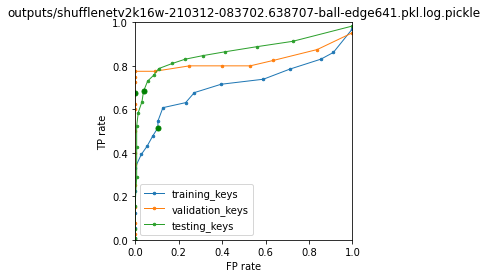

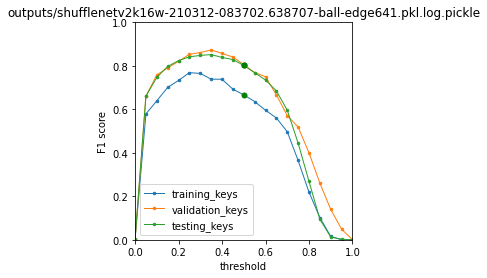

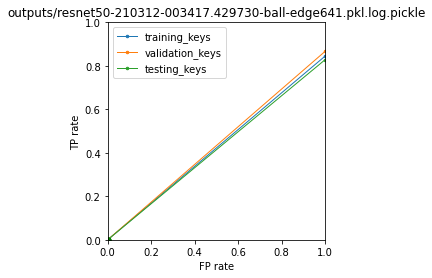

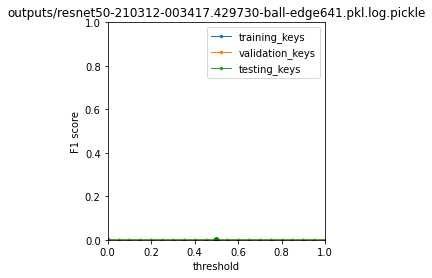

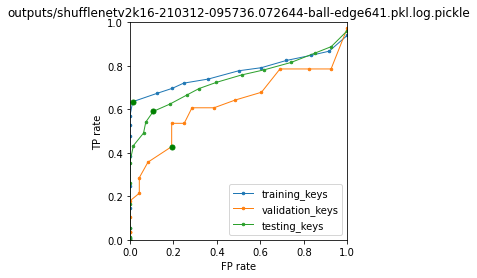

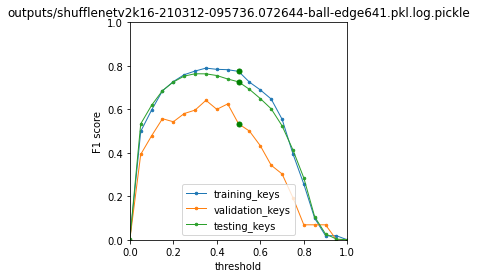

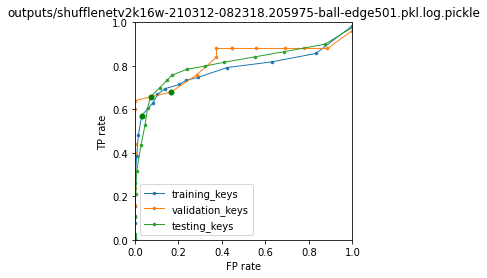

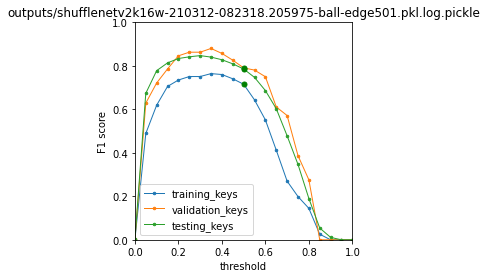

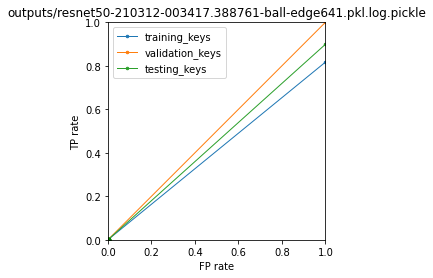

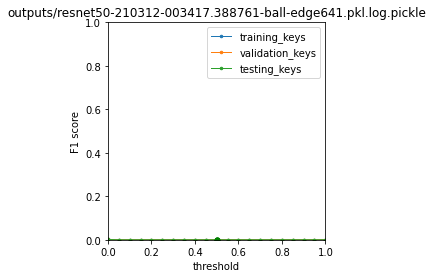

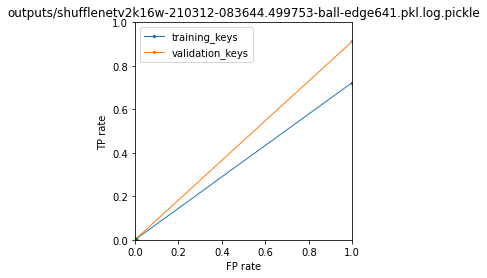

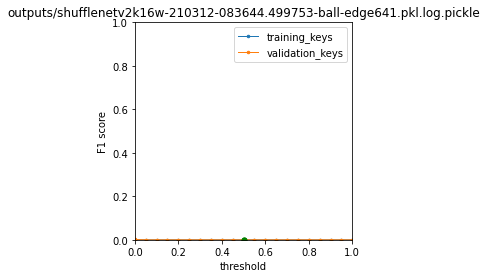

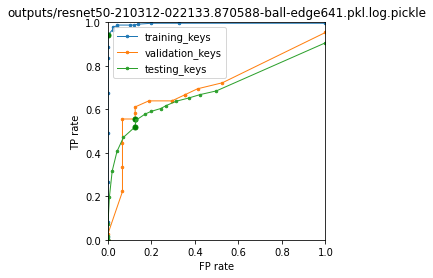

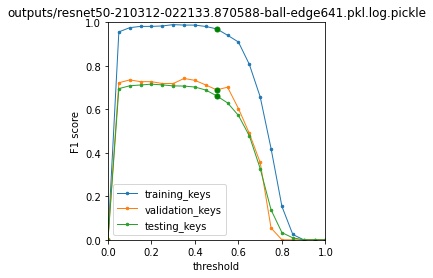

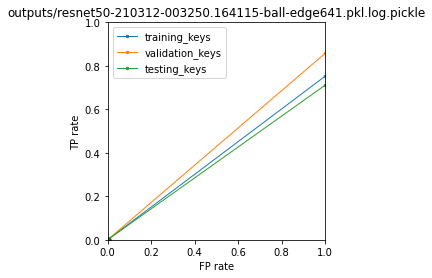

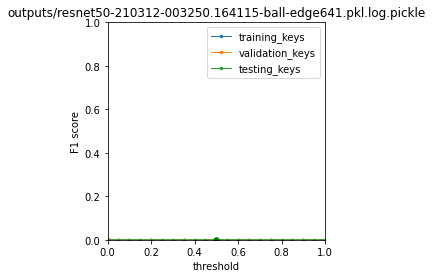

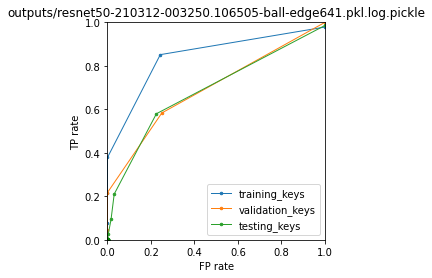

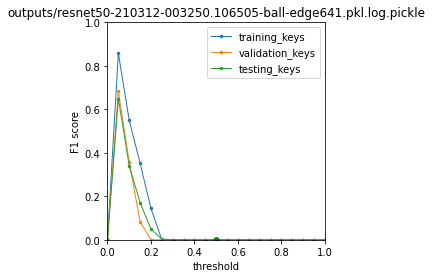

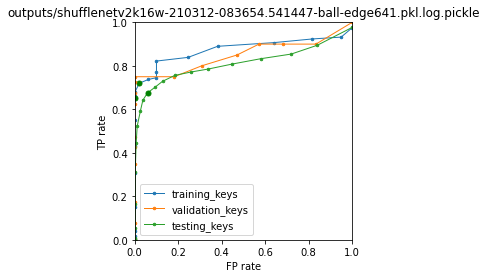

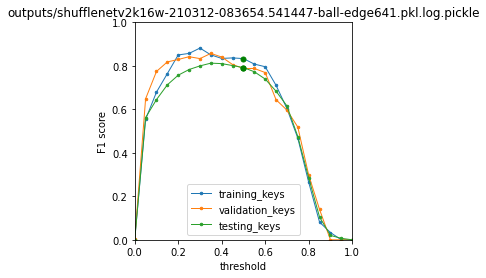

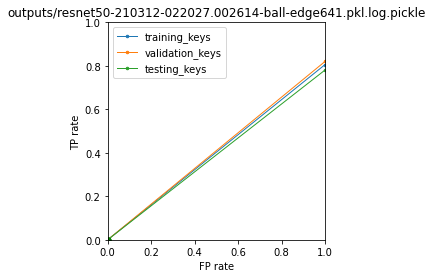

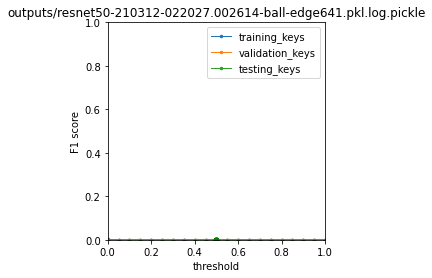

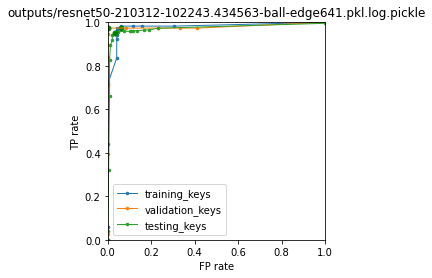

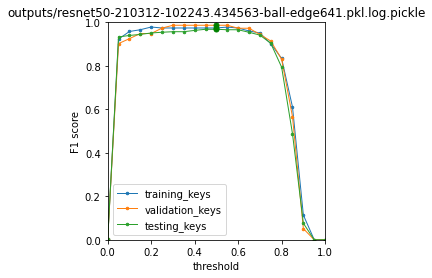

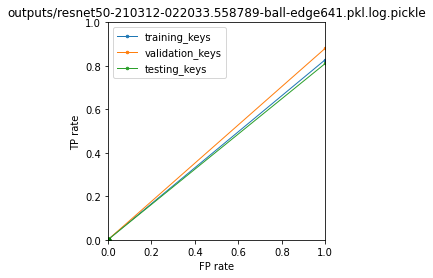

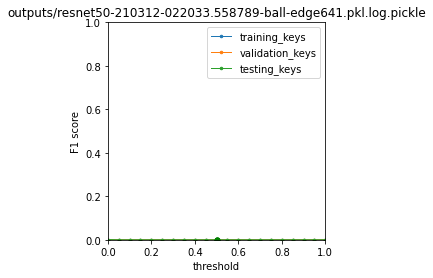

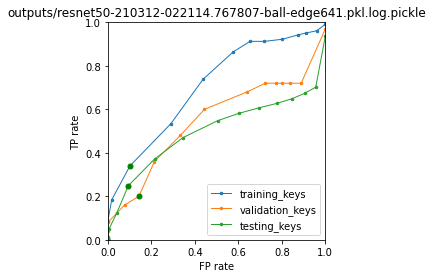

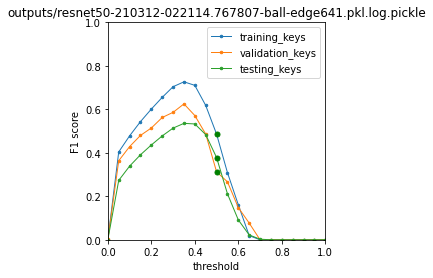

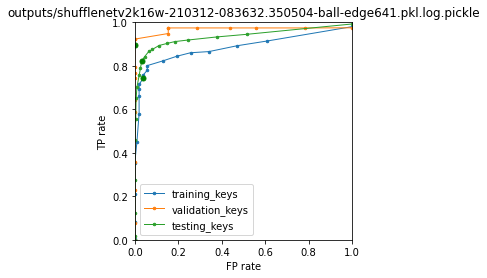

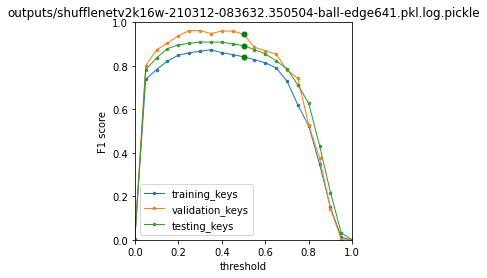

In [14]:
%matplotlib inline
import glob
import pickle

for file in glob.glob("outputs/*210312-*.pickle"):
#for file in glob.glob("outputs/*.pickle"):
    print(file)
    d = pickle.load(open(file, "rb"))
    fig1 = None
    fig2 = None
    for name in ["training_keys", "validation_keys", "testing_keys"]:
        if name in d:
            fig1 = plot_roc(d[name], name, fig1)
            fig1.gca().set_title(file)
            fig2 = plot_F1(d[name], name, fig2)
            fig2.gca().set_title(file)
            
    fig1.show()
    fig2.show()

In [ ]:
import pickle
pickle.dump(sets_results, open(filename+".pickle", "wb"))
